In [1]:
import numpy as np
import pandas as pd
import random
import torch
import models as MyModels
import time
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

import run_experiment
from run_experiment import generate_data

CUDA is available. Using GPU.


In [2]:

r = np.load('GLV_system_growth_rates.npy')
A = np.load('GLV_system_interactions.npy')
p = np.load('GLV_system_perturbations.npy')
noise = 0.0
density = 4
numspecies = 5
training_size = 100

df_train, df_test, df_validation, perturbations_data_dict = generate_data(r,A,p, noise, density, numspecies, training_size)


/scratch/lsftmp/17104700.tmpdir/ipykernel_460375/1467207357.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('./trained_node_for_plotting_with_rs

exp_15


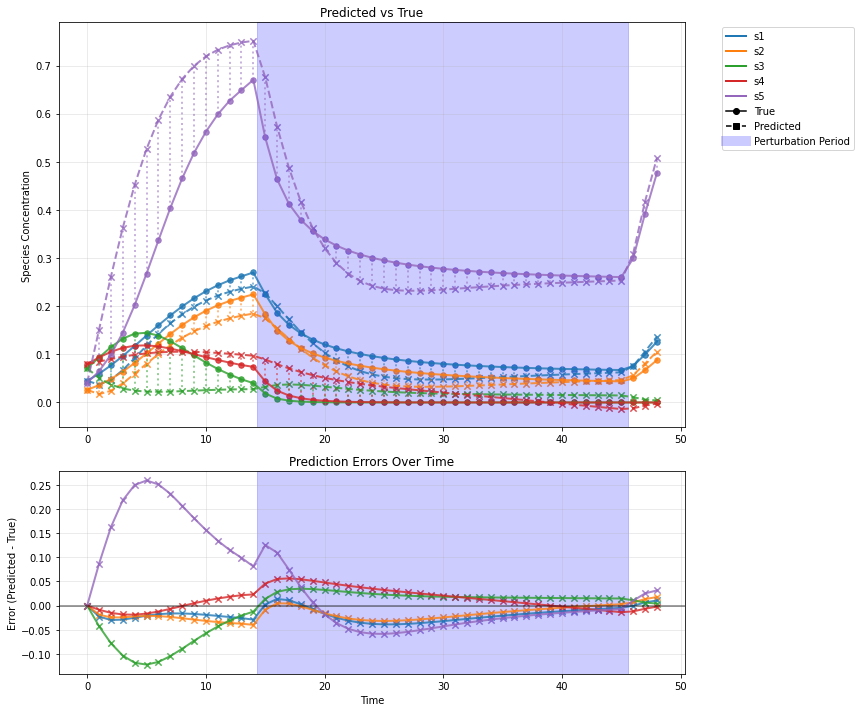

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import random

def make_plot_with_errors(node_model, experiment_name):
    t, y0, y_preds, y_true = MyModels.get_data(experiment_name, node_model, df_test, perturbations_data_dict)
    
    t = t.detach().cpu().numpy()
    y_preds = y_preds.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    errors = y_preds - y_true
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[2, 1])
    colors = plt.cm.tab10(range(5))
    species = ['s1', 's2', 's3', 's4', 's5']
    
    # Main plot: true vs predicted with error bars
    for i in range(5):
        ax1.plot(t, y_true[:, i], color=colors[i], linestyle='-', linewidth=2, alpha=0.8)
        ax1.scatter(t, y_true[:, i], marker='o', color=colors[i], s=30, alpha=0.8)
        ax1.plot(t, y_preds[:, i], color=colors[i], linestyle='--', linewidth=2, alpha=0.8)
        ax1.scatter(t, y_preds[:, i], marker='x', color=colors[i], s=40, alpha=0.8)
        
        # Error bars
        for j in range(len(t)):
            ax1.plot([t[j], t[j]], [y_true[j, i], y_preds[j, i]], 
                    color=colors[i], linestyle=':', alpha=0.5, linewidth=2)
    
    start, stop = perturbations_data_dict[experiment_name]
    ax1.axvspan(start, stop, color='blue', alpha=0.2)
    
    # Create custom legend
    from matplotlib.lines import Line2D
    legend_elements = []
    
    # Add species legends
    for i, species in enumerate(['s1', 's2', 's3', 's4', 's5']):
        legend_elements.append(Line2D([0], [0], color=colors[i], lw=2, label=f'{species}'))
    
    # Add true vs predicted distinction
    legend_elements.append(Line2D([0], [0], color='black', linestyle='-', marker='o', 
                                 markersize=6, label='True', markerfacecolor='black'))
    legend_elements.append(Line2D([0], [0], color='black', linestyle='--', marker='s', 
                                 markersize=6, label='Predicted', markerfacecolor='black'))
    legend_elements.append(Line2D([0], [0], color='blue', alpha=0.2, lw=10, label='Perturbation Period'))
    
    ax1.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax1.set_ylabel('Species Concentration')
    ax1.set_title(f'Predicted vs True')
    print(experiment_name)
    ax1.grid(True, alpha=0.3)
    
    # Error plot
    for i in range(5):
        ax2.plot(t, errors[:, i], color=colors[i], linewidth=2, alpha=0.8)
        ax2.scatter(t, errors[:, i], marker='x', color=colors[i], s=40, alpha=0.8)
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axvspan(start, stop, color='blue', alpha=0.2)
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Error (Predicted - True)')
    ax2.set_title('Prediction Errors Over Time')
    ax2.grid(True, alpha=0.3)
    # save as eps file
    plt.savefig('predicted_vs_true_timeline.eps', format='eps') 
    plt.tight_layout()
    plt.show()
    
node_model = MyModels.PureNeuralODE(input_size = numspecies).to(device)
state_dict = torch.load('./trained_node_for_plotting_with_rsquared_0-95.pt')
node_model.load_state_dict(state_dict)
node_model.to(device)
experiment_name = df_test['Experiments'].unique()[20]
make_plot_with_errors(node_model, experiment_name)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


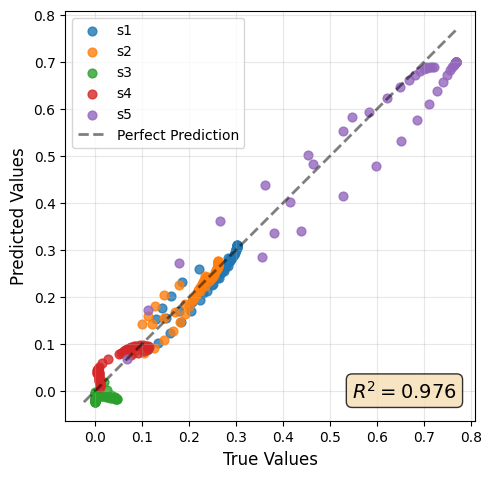

In [15]:
def make_scatter_plot(node_model, experiment_name):
    t, y0, y_preds, y_true = MyModels.get_data(experiment_name, node_model, df_test, perturbations_data_dict)
    
    y_preds = y_preds.detach().cpu().numpy()
    y_true = y_true.detach().cpu().numpy()
    
    # Calculate R^2
    from sklearn.metrics import r2_score
    y_true_all = y_true.flatten()
    y_preds_all = y_preds.flatten()
    r2 = r2_score(y_true_all, y_preds_all)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    colors = plt.cm.tab10(range(5))
    species = ['s1', 's2', 's3', 's4', 's5']
    
    # Flatten and plot each species
    for i in range(5):
        # Flatten all time points for this species
        y_true_flat = y_true[:, i].flatten()
        y_preds_flat = y_preds[:, i].flatten()
        
        ax.scatter(y_true_flat, y_preds_flat, 
                  color=colors[i], s=40, alpha=0.8, 
                  label=species[i])
    
    # Add diagonal line (perfect prediction)
    min_val = min(y_true.min(), y_preds.min())
    max_val = max(y_true.max(), y_preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 
            'k--', linewidth=2, alpha=0.5, label='Perfect Prediction')
    
    # Add R^2 text box
    textstr = f'$R^2 = {r2:.3f}$'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.7, 0.1, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    ax.set_xlabel('True Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    # ax.set_title(f'Predicted vs True Values - {experiment_name}', fontsize=14)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.savefig('predicted_vs_true_scatter.eps', format='eps')
    plt.show()

node_model = MyModels.PureNeuralODE(input_size = numspecies).to(device)
state_dict = torch.load('./trained_node_for_plotting_with_rsquared_0-95.pt')
node_model.load_state_dict(state_dict)
node_model.to(device)
experiment_name = df_test['Experiments'].unique()[20]
make_scatter_plot(node_model, experiment_name)